In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input
from keras import backend as K
from keras import layers, models
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

from spec_generator_sequence import spec_generator
from spec_generator_sequence_multilabel import (spec_generator_multi,
                                                spec_generator_multioutput)
from spec_input_generator import gen, gen_eval
from spectrogram_class import spectrogram


In [2]:

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-07-25 22:19:56.788049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 22:19:56.832725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 22:19:56.844805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 22:19:56.845529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

True

In [3]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [4]:
meta_df.shape

(13265, 17)

In [5]:
meta_df = meta_df[~meta_df['Pitch ID (if applicable)'].isna()]

In [6]:
meta_df.isna().sum()

Path                              0
Family (abbr.)                    0
Family (in full)                  0
Instrument (abbr.)                0
Instrument (in full)              0
Technique (abbr.)                 0
Technique (in full)               0
Pitch                             0
Pitch ID (if applicable)          0
Dynamics                          0
Dynamics ID (if applicable)     568
Instance ID                       0
Mute (abbr.)                      0
Mute (in full)                    0
String ID (if applicable)      5666
Needed digital retuning           0
Fold                              0
dtype: int64

In [7]:
meta_df.shape

(13162, 17)

In [8]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


In [9]:
from random import random


train_df, test_df = train_test_split(meta_df, stratify=meta_df['Instrument (in full)'], 
                                            train_size=0.7, random_state= 42)

In [10]:
multi_generator = spec_generator_multi(train_df, 32)

In [11]:
_, num_target = multi_generator.__getitem__(2)[1].shape
print(num_target)

107


In [17]:
_, num_row, num_col= multi_generator.__getitem__(2)[0].shape
print(num_row)
print(num_col)

500
256


In [18]:
BATCH_SIZE = 32


train_generator = (tf.data.Dataset.from_generator(lambda: spec_generator_multi(train_df, BATCH_SIZE), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, num_row, num_col), 
                 (BATCH_SIZE, num_target)))).prefetch((tf.data.experimental.AUTOTUNE))

eval_generator = (tf.data.Dataset.from_generator(lambda: spec_generator_multi(test_df, BATCH_SIZE), 
                    output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, num_row, num_col), 
                 (BATCH_SIZE, num_target)))).prefetch((tf.data.experimental.AUTOTUNE))


2022-07-25 22:20:26.107875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 22:20:26.108810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 22:20:26.109645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 22:20:26.112032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 22:20:26.112827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [19]:


rnn = Sequential()

rnn.add(layers.InputLayer((num_row, num_col), batch_size= BATCH_SIZE))
rnn.add(LSTM(500))
rnn.add(layers.Dropout(0.2))
rnn.add(layers.Dense(50, activation = 'relu'))
rnn.add(layers.Dense(num_target, activation = 'sigmoid'))



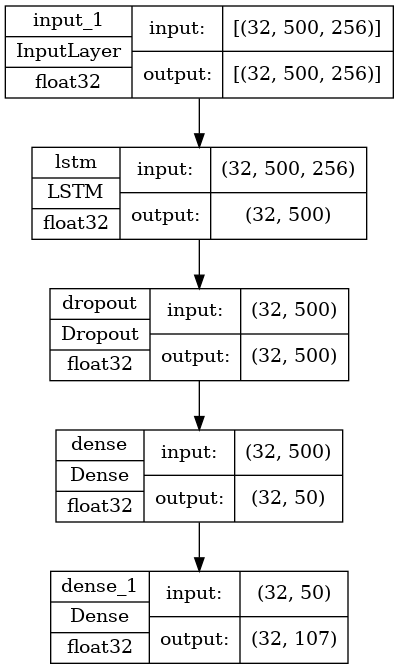

In [20]:
tf.keras.utils.plot_model(rnn, show_shapes = True, show_dtype= True)

In [21]:
rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])

In [ ]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = rnn.fit(train_generator, epochs = 4, verbose=1, 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

In [ ]:
test = meta_df.sample(1)[['Path', 'Instrument (in full)', 'Pitch ID (if applicable)']]

In [ ]:
test

In [ ]:
test_spec = spectrogram(test['Path'].values[0])

In [ ]:
test_spec.spec

In [ ]:
test_spec.spec.shape

In [ ]:
np.reshape(test_spec.spec, (256, 500, 1)).shape

In [ ]:
np.reshape(multi_generator.__getitem__(2)[0]).shape

In [ ]:
rnn.predict_(multi_generator.__getitem__(2)[0])[0]

In [ ]:
multi_generator.__getitem__(2)[0][0].shape

# Rnn two onte-hot target

In [22]:
from unicodedata import name


inp = Input((num_row, num_col), batch_size=BATCH_SIZE, )
x = LSTM(200)(inp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
out1 = layers.Dense(16, activation = 'softmax', name = 'out1')(x)

y = LSTM(200)(inp)
y = layers.Dropout(0.2)(y)
y = layers.Dense(200, activation = 'relu')(y)
y = layers.BatchNormalization()(y)
out2 = layers.Dense(107-16, activation = 'softmax', name = 'out2')(y)

model_2conv_two_out = Model(inp, [out1, out2])

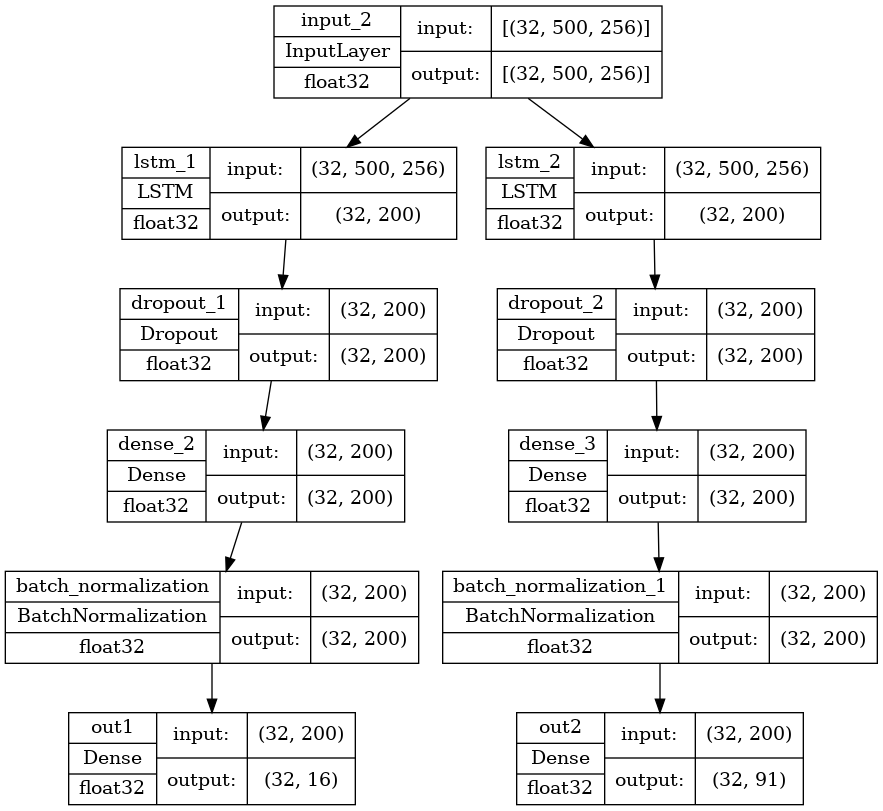

In [23]:
tf.keras.utils.plot_model(model_2conv_two_out, show_shapes=True, show_dtype=True)

In [24]:
model_2conv_two_out.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(32, 500, 256)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (32, 200)            365600      ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (32, 200)            365600      ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (32, 200)            0           ['lstm_1[0][0]']                 
                                                                                              

In [25]:
model_2conv_two_out.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss={'out1': tf.keras.losses.CategoricalCrossentropy(),
                    'out2': tf.keras.losses.CategoricalCrossentropy()},
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [26]:
multioutput_generator = spec_generator_multioutput(train_df, 32)
multioutput_test_generator = spec_generator_multioutput(test_df, 32)

In [27]:
multioutput_generator.__getitem__(32)[0].shape

(32, 500, 256)

In [28]:
# model_2conv_two_out = models.load_model('../models/rnn/first/')

In [29]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn_multioutput", 
                                                    monitor='val_accuracy',
                                                    save_freq = 287*5)
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

history = model_2conv_two_out.fit(multioutput_generator, epochs=100, 
                        validation_data= multioutput_test_generator, 
                        callbacks=[ckpt_callback])

Epoch 1/100


2022-07-25 22:20:39.669109: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


287/287 [==============================] - 48s 152ms/step - loss: 6.9008 - out1_loss: 2.5946 - out2_loss: 4.3062 - out1_accuracy: 0.1430 - out1_auc_1: 0.6779 - out2_accuracy: 0.0205 - out2_auc_1: 0.6742 - val_loss: 6.7797 - val_out1_loss: 2.5590 - val_out2_loss: 4.2207 - val_out1_accuracy: 0.1253 - val_out1_auc_1: 0.6853 - val_out2_accuracy: 0.0236 - val_out2_auc_1: 0.6962
Epoch 2/100
287/287 [==============================] - 43s 149ms/step - loss: 6.9044 - out1_loss: 2.6436 - out2_loss: 4.2607 - out1_accuracy: 0.1466 - out1_auc_1: 0.6720 - out2_accuracy: 0.0240 - out2_auc_1: 0.6864 - val_loss: 6.9560 - val_out1_loss: 2.6961 - val_out2_loss: 4.2599 - val_out1_accuracy: 0.1476 - val_out1_auc_1: 0.6842 - val_out2_accuracy: 0.0249 - val_out2_auc_1: 0.6825
Epoch 3/100
287/287 [==============================] - 43s 150ms/step - loss: 6.7598 - out1_loss: 2.5205 - out2_loss: 4.2392 - out1_accuracy: 0.1907 - out1_auc_1: 0.7072 - out2_accuracy: 0.0241 - out2_auc_1: 0.6904 - val_loss: 7.1583 - 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_05_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_05_rnn_multioutput/assets


287/287 [==============================] - 56s 194ms/step - loss: 6.6136 - out1_loss: 2.3902 - out2_loss: 4.2234 - out1_accuracy: 0.2330 - out1_auc_1: 0.7442 - out2_accuracy: 0.0225 - out2_auc_1: 0.6938 - val_loss: 6.6466 - val_out1_loss: 2.4163 - val_out2_loss: 4.2303 - val_out1_accuracy: 0.2426 - val_out1_auc_1: 0.7488 - val_out2_accuracy: 0.0236 - val_out2_auc_1: 0.6973
Epoch 6/100
287/287 [==============================] - 45s 157ms/step - loss: 6.5696 - out1_loss: 2.3455 - out2_loss: 4.2242 - out1_accuracy: 0.2442 - out1_auc_1: 0.7598 - out2_accuracy: 0.0187 - out2_auc_1: 0.6937 - val_loss: 6.7604 - val_out1_loss: 2.5428 - val_out2_loss: 4.2176 - val_out1_accuracy: 0.2482 - val_out1_auc_1: 0.7254 - val_out2_accuracy: 0.0226 - val_out2_auc_1: 0.6995
Epoch 7/100
287/287 [==============================] - 47s 163ms/step - loss: 6.5657 - out1_loss: 2.3428 - out2_loss: 4.2229 - out1_accuracy: 0.2425 - out1_auc_1: 0.7587 - out2_accuracy: 0.0236 - out2_auc_1: 0.6945 - val_loss: 6.6355 - 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_10_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_10_rnn_multioutput/assets


287/287 [==============================] - 63s 221ms/step - loss: 5.5953 - out1_loss: 2.2254 - out2_loss: 3.3699 - out1_accuracy: 0.2775 - out1_auc_1: 0.7908 - out2_accuracy: 0.1709 - out2_auc_1: 0.8469 - val_loss: 6.1675 - val_out1_loss: 3.2642 - val_out2_loss: 2.9032 - val_out1_accuracy: 0.2353 - val_out1_auc_1: 0.7008 - val_out2_accuracy: 0.2818 - val_out2_auc_1: 0.8861
Epoch 11/100
287/287 [==============================] - 47s 163ms/step - loss: 5.0134 - out1_loss: 2.1398 - out2_loss: 2.8736 - out1_accuracy: 0.2957 - out1_auc_1: 0.8142 - out2_accuracy: 0.2905 - out2_auc_1: 0.8885 - val_loss: 4.8963 - val_out1_loss: 2.2788 - val_out2_loss: 2.6175 - val_out1_accuracy: 0.2612 - val_out1_auc_1: 0.8033 - val_out2_accuracy: 0.3559 - val_out2_auc_1: 0.8962
Epoch 12/100
287/287 [==============================] - 52s 182ms/step - loss: 4.7099 - out1_loss: 2.2461 - out2_loss: 2.4638 - out1_accuracy: 0.2642 - out1_auc_1: 0.7880 - out2_accuracy: 0.3880 - out2_auc_1: 0.9148 - val_loss: 4.5799 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_15_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_15_rnn_multioutput/assets


287/287 [==============================] - 66s 229ms/step - loss: 3.9259 - out1_loss: 2.0702 - out2_loss: 1.8557 - out1_accuracy: 0.3213 - out1_auc_1: 0.8291 - out2_accuracy: 0.5345 - out2_auc_1: 0.9472 - val_loss: 3.8303 - val_out1_loss: 2.0548 - val_out2_loss: 1.7756 - val_out1_accuracy: 0.3270 - val_out1_auc_1: 0.8319 - val_out2_accuracy: 0.5513 - val_out2_auc_1: 0.9518
Epoch 16/100
287/287 [==============================] - 47s 164ms/step - loss: 3.7746 - out1_loss: 2.0538 - out2_loss: 1.7207 - out1_accuracy: 0.3262 - out1_auc_1: 0.8321 - out2_accuracy: 0.5611 - out2_auc_1: 0.9541 - val_loss: 3.7965 - val_out1_loss: 2.1156 - val_out2_loss: 1.6808 - val_out1_accuracy: 0.3122 - val_out1_auc_1: 0.8182 - val_out2_accuracy: 0.5795 - val_out2_auc_1: 0.9555
Epoch 17/100
287/287 [==============================] - 51s 179ms/step - loss: 3.6329 - out1_loss: 1.9906 - out2_loss: 1.6423 - out1_accuracy: 0.3368 - out1_auc_1: 0.8460 - out2_accuracy: 0.5764 - out2_auc_1: 0.9570 - val_loss: 3.6658 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_20_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_20_rnn_multioutput/assets


287/287 [==============================] - 72s 251ms/step - loss: 3.4215 - out1_loss: 1.9724 - out2_loss: 1.4490 - out1_accuracy: 0.3506 - out1_auc_1: 0.8485 - out2_accuracy: 0.6260 - out2_auc_1: 0.9643 - val_loss: 3.7123 - val_out1_loss: 2.1533 - val_out2_loss: 1.5590 - val_out1_accuracy: 0.3178 - val_out1_auc_1: 0.8285 - val_out2_accuracy: 0.6047 - val_out2_auc_1: 0.9625
Epoch 21/100
287/287 [==============================] - 47s 163ms/step - loss: 3.3211 - out1_loss: 1.9268 - out2_loss: 1.3943 - out1_accuracy: 0.3479 - out1_auc_1: 0.8580 - out2_accuracy: 0.6327 - out2_auc_1: 0.9672 - val_loss: 3.6073 - val_out1_loss: 2.0581 - val_out2_loss: 1.5493 - val_out1_accuracy: 0.3318 - val_out1_auc_1: 0.8320 - val_out2_accuracy: 0.6095 - val_out2_auc_1: 0.9575
Epoch 22/100
287/287 [==============================] - 62s 216ms/step - loss: 3.3057 - out1_loss: 1.9518 - out2_loss: 1.3539 - out1_accuracy: 0.3470 - out1_auc_1: 0.8526 - out2_accuracy: 0.6456 - out2_auc_1: 0.9678 - val_loss: 3.5194 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_25_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_25_rnn_multioutput/assets


287/287 [==============================] - 74s 258ms/step - loss: 3.0199 - out1_loss: 1.8157 - out2_loss: 1.2041 - out1_accuracy: 0.3948 - out1_auc_1: 0.8751 - out2_accuracy: 0.6867 - out2_auc_1: 0.9739 - val_loss: 3.3700 - val_out1_loss: 1.9541 - val_out2_loss: 1.4160 - val_out1_accuracy: 0.3562 - val_out1_auc_1: 0.8529 - val_out2_accuracy: 0.6471 - val_out2_auc_1: 0.9629
Epoch 26/100
287/287 [==============================] - 51s 179ms/step - loss: 3.1751 - out1_loss: 1.7724 - out2_loss: 1.4027 - out1_accuracy: 0.4076 - out1_auc_1: 0.8820 - out2_accuracy: 0.6441 - out2_auc_1: 0.9628 - val_loss: 3.9168 - val_out1_loss: 1.8661 - val_out2_loss: 2.0507 - val_out1_accuracy: 0.3897 - val_out1_auc_1: 0.8677 - val_out2_accuracy: 0.5234 - val_out2_auc_1: 0.9130
Epoch 27/100
287/287 [==============================] - 54s 186ms/step - loss: 3.3967 - out1_loss: 1.7089 - out2_loss: 1.6878 - out1_accuracy: 0.4286 - out1_auc_1: 0.8913 - out2_accuracy: 0.5834 - out2_auc_1: 0.9495 - val_loss: 3.9486 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_30_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_30_rnn_multioutput/assets


287/287 [==============================] - 69s 241ms/step - loss: 2.7923 - out1_loss: 1.5696 - out2_loss: 1.2227 - out1_accuracy: 0.4752 - out1_auc_1: 0.9096 - out2_accuracy: 0.6745 - out2_auc_1: 0.9736 - val_loss: 3.1477 - val_out1_loss: 1.7569 - val_out2_loss: 1.3908 - val_out1_accuracy: 0.4172 - val_out1_auc_1: 0.8856 - val_out2_accuracy: 0.6603 - val_out2_auc_1: 0.9609
Epoch 31/100
287/287 [==============================] - 53s 186ms/step - loss: 3.1124 - out1_loss: 1.7636 - out2_loss: 1.3488 - out1_accuracy: 0.4115 - out1_auc_1: 0.8827 - out2_accuracy: 0.6542 - out2_auc_1: 0.9665 - val_loss: 3.2544 - val_out1_loss: 1.8333 - val_out2_loss: 1.4211 - val_out1_accuracy: 0.4088 - val_out1_auc_1: 0.8756 - val_out2_accuracy: 0.6413 - val_out2_auc_1: 0.9638
Epoch 32/100
287/287 [==============================] - 52s 180ms/step - loss: 2.7679 - out1_loss: 1.6031 - out2_loss: 1.1648 - out1_accuracy: 0.4680 - out1_auc_1: 0.9051 - out2_accuracy: 0.6901 - out2_auc_1: 0.9754 - val_loss: 3.0773 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_35_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220725_222035_35_rnn_multioutput/assets


287/287 [==============================] - 77s 265ms/step - loss: 2.4537 - out1_loss: 1.4264 - out2_loss: 1.0273 - out1_accuracy: 0.5252 - out1_auc_1: 0.9262 - out2_accuracy: 0.7300 - out2_auc_1: 0.9786 - val_loss: 3.0146 - val_out1_loss: 1.6510 - val_out2_loss: 1.3636 - val_out1_accuracy: 0.4499 - val_out1_auc_1: 0.8996 - val_out2_accuracy: 0.6669 - val_out2_auc_1: 0.9625
Epoch 36/100
287/287 [==============================] - 51s 178ms/step - loss: 2.4261 - out1_loss: 1.4313 - out2_loss: 0.9948 - out1_accuracy: 0.5185 - out1_auc_1: 0.9254 - out2_accuracy: 0.7360 - out2_auc_1: 0.9798 - val_loss: 2.9836 - val_out1_loss: 1.6399 - val_out2_loss: 1.3437 - val_out1_accuracy: 0.4576 - val_out1_auc_1: 0.9020 - val_out2_accuracy: 0.6766 - val_out2_auc_1: 0.9618
Epoch 37/100
287/287 [==============================] - 54s 187ms/step - loss: 2.3987 - out1_loss: 1.4179 - out2_loss: 0.9808 - out1_accuracy: 0.5222 - out1_auc_1: 0.9269 - out2_accuracy: 0.7415 - out2_auc_1: 0.9802 - val_loss: 3.0062 

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model_2conv_two_out.save('../models/rnn_normalized/second')

In [ ]:
%load_ext tensorboard

In [ ]:
!tensorboard dev upload \
    -y \
  --logdir logs \
  --name "Sample op-level graph" \
  --one_shot

# Conv + RNN

In [14]:
multioutput_generator_convlstm = spec_generator_multioutput(train_df, 8)
multioutput_test_generator_convlstm = spec_generator_multioutput(test_df, 8)

In [15]:

inp = Input((num_row, num_col, 1), batch_size=8, )
x = layers.ConvLSTM1D(20, 150, kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(inp)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(30, (30))(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(30, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
out1 = layers.Dense(16, activation = 'softmax', name = 'out1')(x)

y = layers.ConvLSTM1D(20, 150, kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(inp) 
y = layers.Dropout(0.2)(y)
y = layers.MaxPooling1D(2)(y)
y = layers.Conv1D(30, (30))(y)
y = layers.MaxPooling1D(2)(y)
y = layers.Flatten()(y)
y = layers.Dense(30, activation = 'relu')(y)
y = layers.BatchNormalization()(y)
out2 = layers.Dense(107-16, activation = 'softmax', name = 'out2')(y)

model_convlstm = Model(inp, [out1, out2])

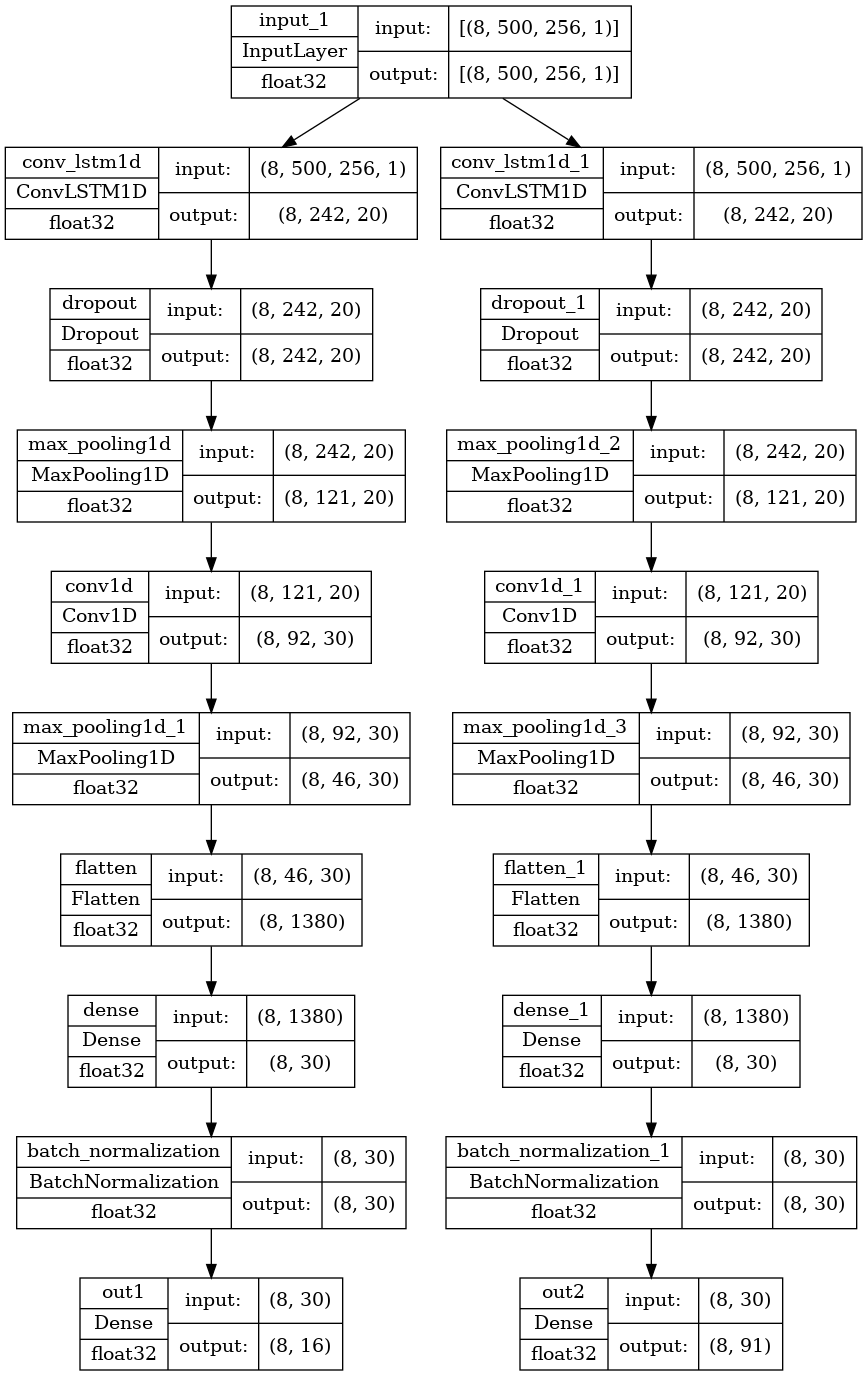

In [16]:
tf.keras.utils.plot_model(model_convlstm , show_shapes=True, show_dtype=True)

In [17]:
model_convlstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(8, 500, 256, 1)]   0           []                               
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (8, 242, 20)         25280       ['input_1[0][0]']                
                                                                                                  
 conv_lstm1d_1 (ConvLSTM1D)     (8, 242, 20)         25280       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (8, 242, 20)         0           ['conv_lstm1d[0][0]']            
                                                                                              

In [18]:

model_convlstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss={'out1': tf.keras.losses.CategoricalCrossentropy(),
                    'out2': tf.keras.losses.CategoricalCrossentropy()},
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [19]:
!pwd

/bin/bash: /home/shiya/anaconda3/envs/music/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/shiya/Documents/music_transcription/notebooks


In [20]:
new_path = !find ../models/baseline_checkpoint/*rnn_convlstm -maxdepth 0 | sort -nr | head -1
new_path = new_path[1]

In [21]:
print(new_path)

../models/baseline_checkpoint/20220725_132741_02_rnn_convlstm


In [22]:
model_convlstm = tf.keras.models.load_model(new_path)

In [23]:

from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn_convlstm", 
                                                    monitor='val_accuracy',
                                                    save_freq = 287*5)
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

history_convlstm = model_convlstm.fit(multioutput_generator_convlstm, epochs=100, 
                        validation_data= multioutput_test_generator_convlstm, 
                        callbacks=[ckpt_callback])

Epoch 1/100


2022-07-25 17:02:48.068190: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-25 17:02:48.731029: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-25 17:02:48.732155: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-25 17:02:48.732609: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-25 17:02:48.733815: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-25 17:02:48.733893: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 275/1151 [======>.......................] - ETA: 40:30 - loss: 6.8122 - out1_loss: 2.5750 - out2_loss: 4.2284 - out1_accuracy: 0.1532 - out1_auc_4: 0.6803 - out2_accuracy: 0.0241 - out2_auc_4: 0.6925

KeyboardInterrupt: 

In [48]:
model_convlstm.save('../models/rnn_convlstm/first')

INFO:tensorflow:Assets written to: ../models/rnn_convlstm/first/assets


INFO:tensorflow:Assets written to: ../models/rnn_convlstm/first/assets
